# Diamond Price Prediction

## Goal
Training a Machine Learning algorithm that predicts the price of diamonds using their features.

## Data
The dataset contains data on 54 000 diamonds ([data source](https://www.kaggle.com/shivam2503/diamonds)).

For each diamond, we have its:
* price: price in US dollars (\\$326 - $18,823)
* carat: weight of the diamond (0.2 - 5.01 ct)
* cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
* color: diamond color, from J (worst) to D (best)
* clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
* x: length in mm (0 - 10.74 mm)
* y: width in mm (0 - 58.9 mm)
* z: depth in mm (0 - 31.8 mm)
* depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43 - 79)
* table: width of top of diamond relative to widest point (43 - 95)

## Notes
In this project, I want to focus on modeling.
I will therefore not go too deep on data exploration & data cleaning.
I am conscious of the fact that these steps are crucial to get the best model, but here my goal is just to practice feature selection & hyerparameter optimization.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
style.use("fivethirtyeight")
mpl.rcParams['figure.dpi']= 300    # tells matplotlib to display inline plots at 300 DPI
mpl.rc("savefig", dpi = 300)       # tells matplotlib to save plots at 300 DPI

# Ignore warnings :
import warnings
warnings.filterwarnings('ignore')

## General Exploration

In [2]:
data = pd.read_csv("diamonds.csv").drop(["Unnamed: 0"], axis=1)    # dropping a useless column
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
carat      53940 non-null float64
cut        53940 non-null object
color      53940 non-null object
clarity    53940 non-null object
depth      53940 non-null float64
table      53940 non-null float64
price      53940 non-null int64
x          53940 non-null float64
y          53940 non-null float64
z          53940 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


* There are no missing values
* Columns seem to be of the appropriate type

## Cleaning Columns

### Numerical Columns 

In [4]:
data.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


x, y and z translate the volume of the diamond. A value of 0 for any of these 3 features does not make sense.

In [5]:
impossible_volume = data[(data["x"] == 0) | (data["y"] == 0) | (data["z"] == 0)]
impossible_volume.shape[0]

20

Only 20 diamonds have impossible volumes (0.04%) so we can safely drop them.

In [6]:
data = data.drop(impossible_volume.index)

### Categorical Cols
3 features of a diamond are categorical:
* cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
* color: diamond color, from J (worst) to D (best)
* clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)) 

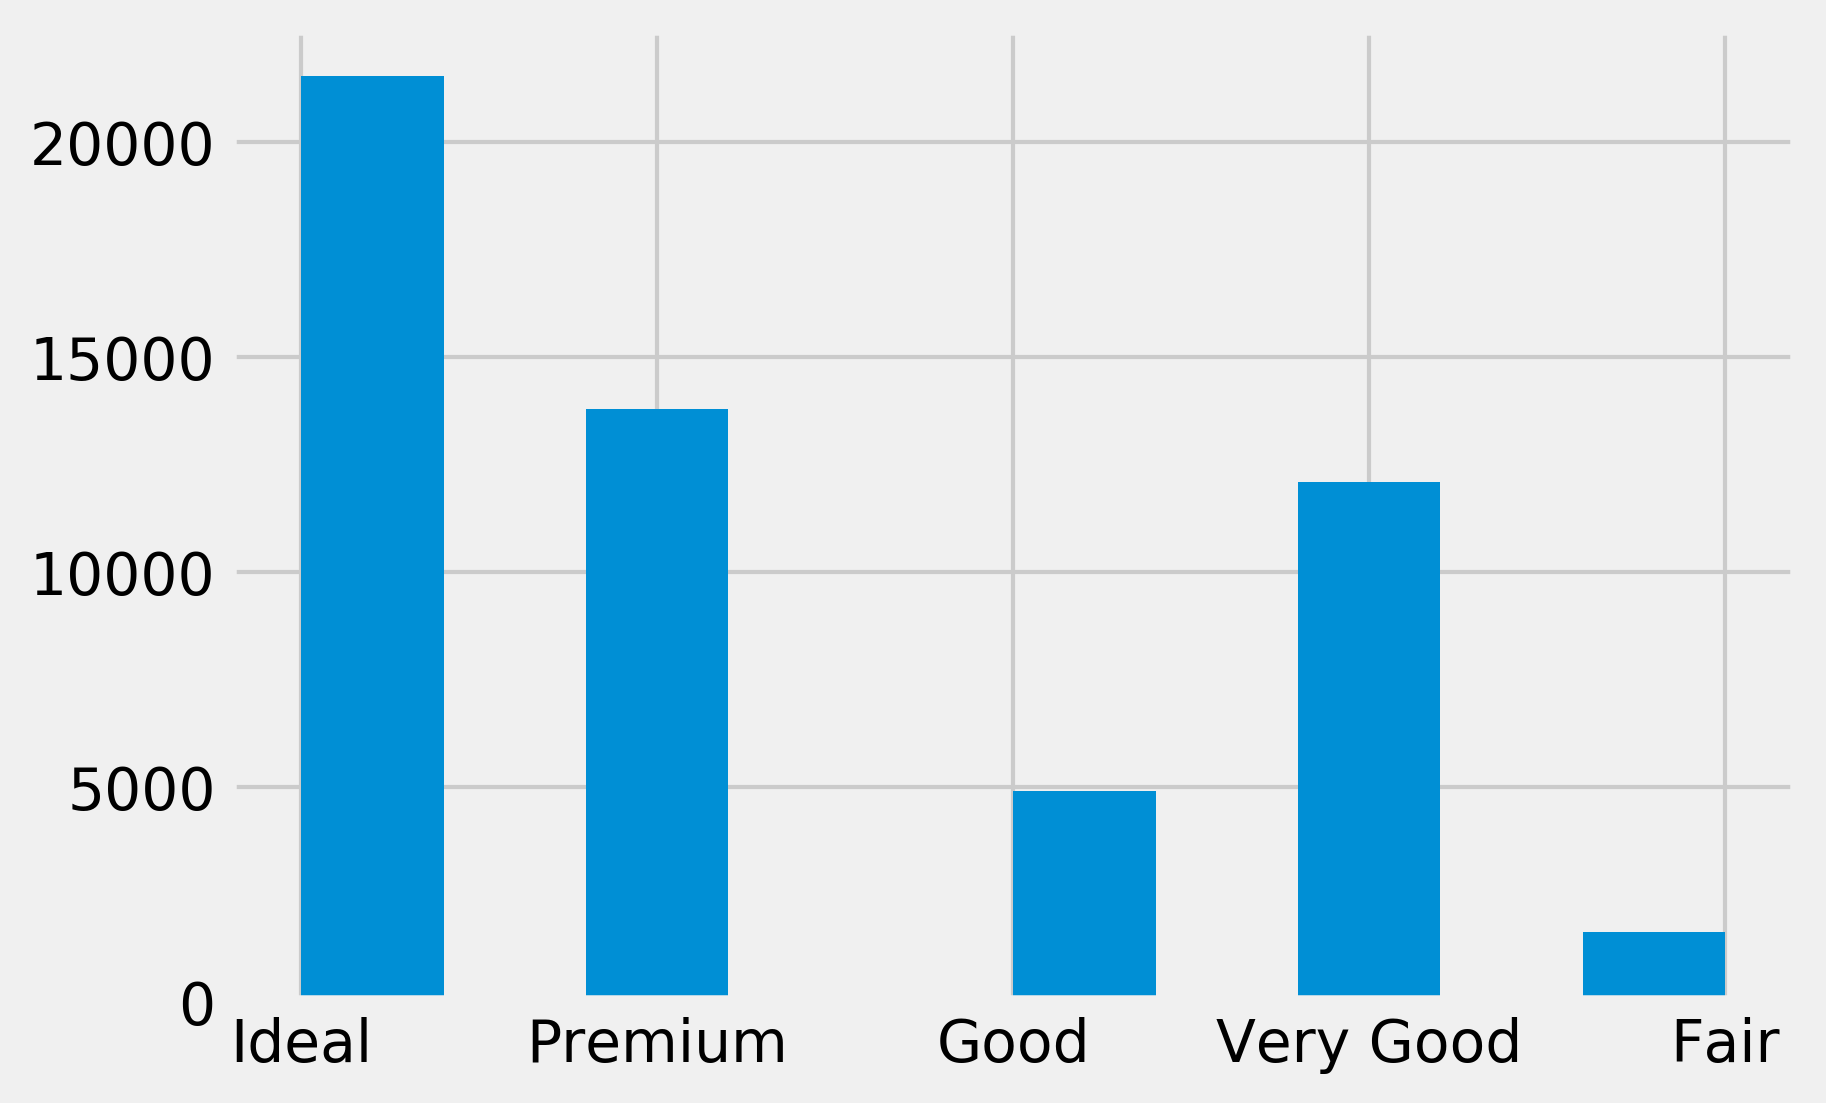

In [12]:
data["cut"].hist()

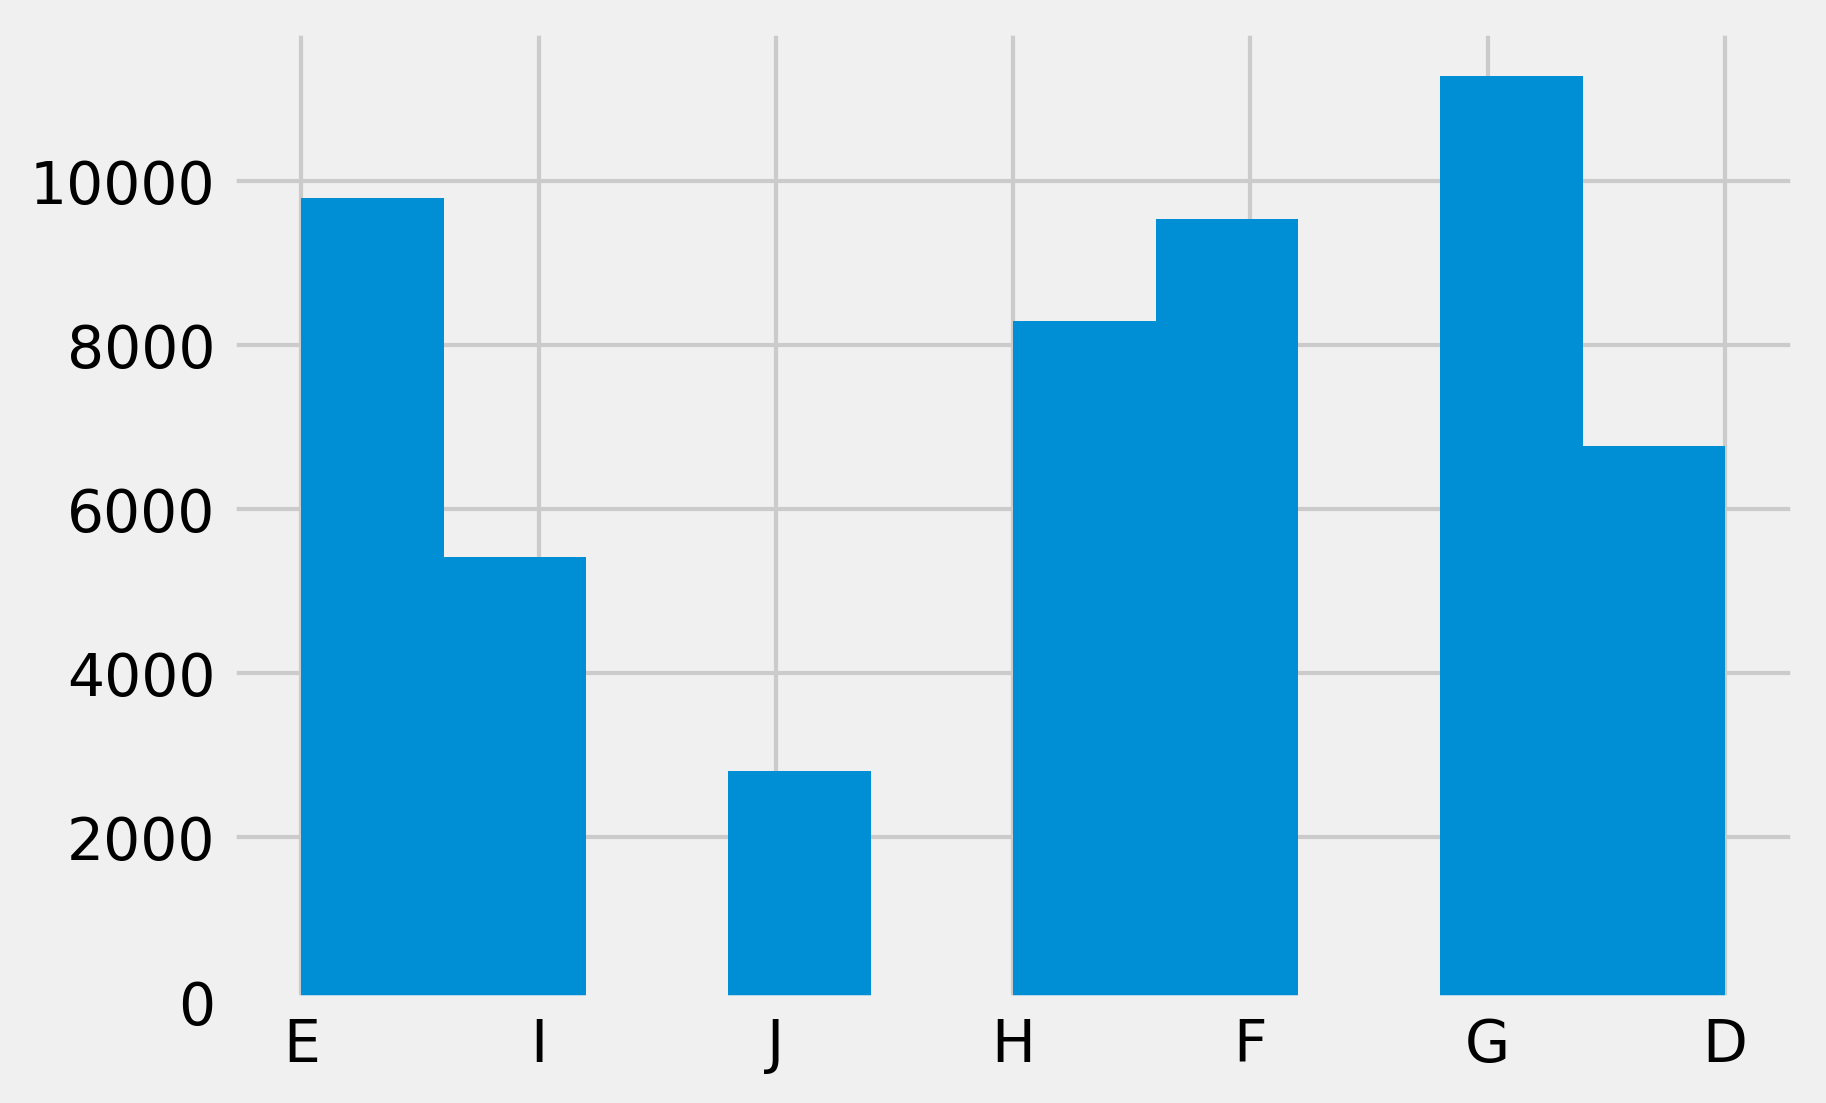

In [13]:
data["color"].hist()

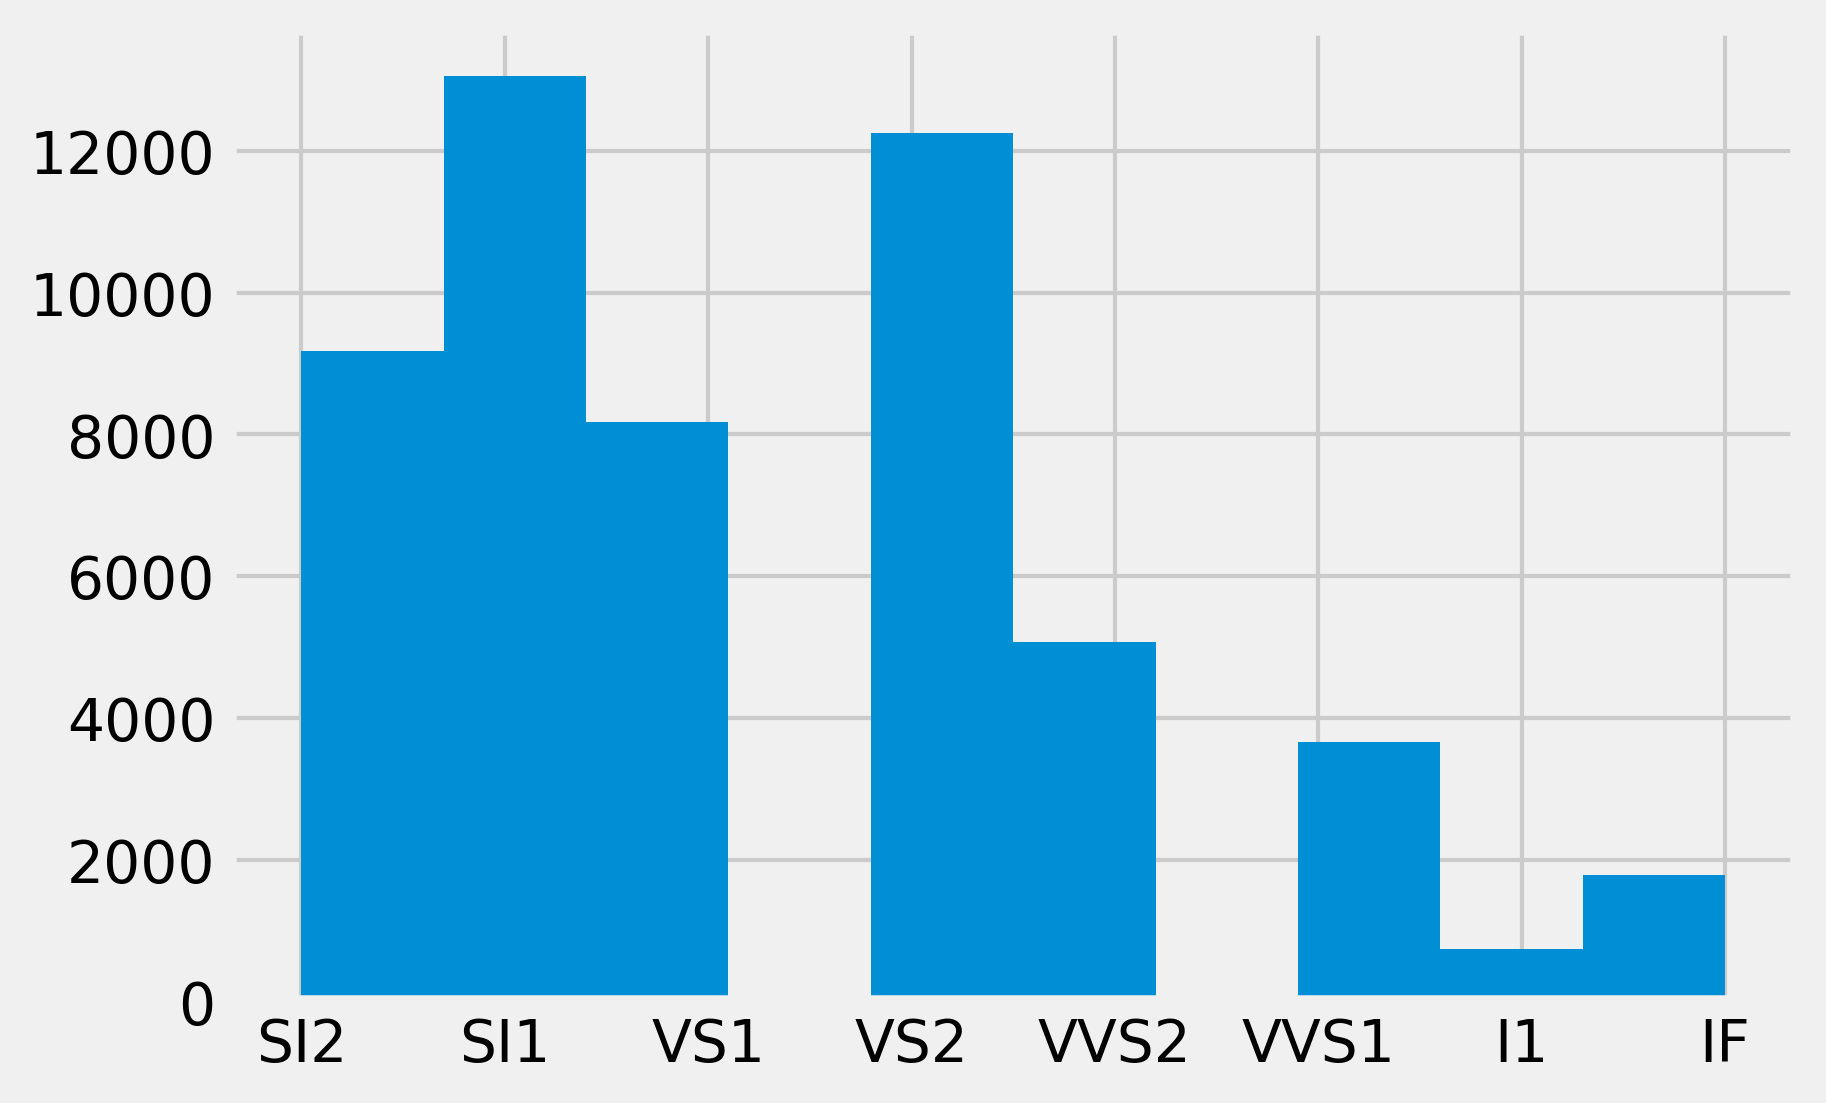

In [14]:
data["clarity"].hist()

We don't see anything clearly abnormal for any category. Each category has at least a few representations, and no category is too dominant.

## Converting categorical features to numeric features
Most machine learning algorithms can only work with numeric data.

We therefore have to convert our categorical features to numeric features. We will do so by splitting a category type into multiple columns (one for each category), and populating them with essentially boolean values (0 or 1) translating the presence or absence of this category.

In [15]:
data = pd.get_dummies(data)    # Generates all the "boolean" columns and concats them with our data. Also removes the old version of each category
data.head()

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0,1,0,...,0,1,0,0,0,1,0,0,0,0


## Feature Engineering
Feature Engineering is the act of creating new features from our current data.

We should not add the features x, y, and z separately to our model as they make more sense when taken together as the volume of the diamond.

In [16]:
data["volume"] = data["x"] * data["y"] * data["z"]
data = data.drop(["x", "y", "z"], axis=1)    # removes individual dimensions that we don't need anymore

## Data Scaling
The values range in a very different way from column to column.
We should rescale them to fit them better to our model.

We will use the min_max scaler. It transforms a column so that values range from 0 to 1:

X_scaled = X_std * (max - min) + min

In [17]:
# Selecting the numeric columns
numeric_data = data.select_dtypes(include=["int64", "float64"])
numeric_cols = numeric_data.drop(["price"], axis=1).columns    # we don't want to scale our target: price
numeric_cols

Index(['carat', 'depth', 'table', 'volume'], dtype='object')

In [18]:
# Scaling
from sklearn.preprocessing import minmax_scale

for col in numeric_cols:
    data[col] = minmax_scale(data[col])
    
data[numeric_cols].head()

,carat,depth,table,volume
0,0.006237,0.513889,0.230769,0.001705
1,0.002079,0.466667,0.346154,0.000735
2,0.006237,0.386111,0.423077,0.001672
3,0.018711,0.538889,0.288462,0.003943
4,0.022869,0.563889,0.288462,0.005306


## Reducing Collinearity
Collinear features are features who are correlated as a pair. They share information, which means that, if we select both of them for our model, we will duplicate part of the information and reduce the effectiveness of our model.

For example, we separated our categories into their components. However, taken together, the components of a category group contain a certain amount of duplicate information: having the presence value of each but one of the categories allow us to find the presence value of the remaining one.

To reduce collinearity between our features, we should drop one category per category group.
We don't lose information by doing this as the value of a category can be retrieved by using the value for all other categories in the group.

For each category group, we will drop the category that contains the least variance, as low variance features tend to be ineffective for our model.

In [19]:
# Return the name of the column of least variance
def find_col_of_least_variance(df):
    deviations = [df[col].std() for col in df.columns]
    min_deviation = np.min(deviations)
    return df.columns[deviations.index(min_deviation)]

# Returns a new DataFrame with the member of least variance of the category dropped
def drop_least_variance_member(df, category):
    members = [col for col in df.columns if col.startswith(category)]
    col_to_drop = find_col_of_least_variance(df[members])
    print("Dropping " + col_to_drop)
    return df.drop([col_to_drop], axis=1)

# Returns a new DataFrame with the member of least variance of each category dropped
def drop_least_variance_members(df, categories):
    for category in categories:
        df = drop_least_variance_member(df, category)
    return df

data_cleaned = drop_least_variance_members(data, ["cut", "color", "clarity"])

Dropping cut_Fair
Dropping color_J
Dropping clarity_I1


## Train/Test split
We want to separate the data our model will used to train from the data it will test itself on.
We will take 80% of our rows (selected randomly) for our train set, and the remaining 20% for our test set.

We will at the same time separate our subsets into two sub-subsets:
* Potential features X: every column but price
* The target y: price

In [20]:
from sklearn.model_selection import train_test_split

target = "price"
X = data_cleaned.drop([target], axis=1)
y = data_cleaned[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

## Feature Selection
There are many different ways to select the right features for our model.
The general idea is to select the combination of features that will result in the best model.

For example, we could take the n features that have the best correlation coefficient with our target, price.
 
The method we are going to use here is called RFECV: feature ranking with recursive feature elimination and cross-validated selection of the best number of features.

It will, using a model (a linear regression model here) try every combination of features by cross-validating (10 folds, explained in the next section) the model. It will then give us a list reflecting the best combination of features, and rank them.

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV

def select_features(X_train, y_train, target): 
    lr = LinearRegression()
    selector = RFECV(lr, cv=10)
    selector.fit(X_train, y_train)
    
    best_columns = list(X_train.columns[selector.support_])
    return best_columns


features = select_features(X_train, y_train, "price")
features

['carat',
 'depth',
 'table',
 'cut_Good',
 'cut_Ideal',
 'cut_Premium',
 'cut_Very Good',
 'color_D',
 'color_E',
 'color_F',
 'color_G',
 'color_H',
 'color_I',
 'clarity_IF',
 'clarity_SI1',
 'clarity_SI2',
 'clarity_VS1',
 'clarity_VS2',
 'clarity_VVS1',
 'clarity_VVS2',
 'volume']

According the the RFECV algorithm, the best linear regression model will use all of our features.

## Validating with Cross-Validation
Cross-validating with 10 folds means that the model will be trained 10 times. A fold is a portion of the data, with 10 folds each fold represents 10% of the data.

At each one the the 10 iterations i, we select the fold n°i as the test set, and the rest as the train set. We then train the model, make prediction on the test set, the compute the prediction's coefficient of determination R².

R² is the coefficient of determination. It's the proportion of the variance in the dependent variable that is predictable from the independent variables. It ranges from 0 to 1, 1 being the best.

When the 10 iterations are done, we return the mean of our 10 coefficients.
Performing cross-validation allows us to check if our model overfits our training data by testing it on different permutations of the data.

In [26]:
from sklearn.model_selection import cross_val_score

lr = LinearRegression()
scores = cross_val_score(lr, X_train[features], y_train, cv=10)
accuracy = scores.mean()
print(accuracy) # accuracy is measured as R²: coefficient of determination [0:1]

0.8965064444787526


Our cross-validation score is around 89.7%.

It means that, for this model, 89.7% of the total variation in our real prices is explained by the variation in our linear regression line (which is our model). It also means that 10.3% of this variation is not explained by our model.

This cross-validation score is quite high as it's close to 100%: our model fits the data well.

## Predicting
Now that we validated our model, we can use it to make predictions on our test data.

In [27]:
lr.fit(X_train[features], y_train)
predictions = lr.predict(X_test[features])

## Error
How far are our predictions from reality?

We will measure our error with:
* R²: Coefficient of determination. It's the proportion of the variance in the dependent variable that is predictable from the independent variables. It ranges from 0 to 1, 1 being the best.
* MSE: Mean squared error. It measures the average of the squares of the errors. The closer it is to 0 the better.
* RMSE: Root mean squared error. It measures the standard deviation of the errors. The it is to 0 the better. It's expressed in the target's unit, which here means that it's expressed in $.

In [28]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

r_squarred = r2_score(predictions, y_test)
mse = mean_squared_error(predictions, y_test)
rmse = np.sqrt(mse)
print("R² score: " + str(r_squarred))
print("MSE:      " + str(mse))
print("RMSE:     " + str(rmse))

R² score: 0.9082249818261265
MSE:      1263702.4020779473
RMSE:     1124.145187276958


* Our coefficient of determination R² for one iteration or predictions is 90.1%, which is quite high.
* R² did not increase by much (1.3%) when going from cross-validation to simple prediction. It is reassuring as a high increase in R² would mean that our model is overfitting the test data: it tries to fit his training data too precisely and misses the general trend, loosing its ability to be generalized to other data points.
* The mean squared error MSE of our predictions is 1 263 702. It means that, on average, the error we get when predicting a price squared is 1 263 702. This metric penalizes errors relative to their size in a linear way: an error of \\$10 is twice as bad as an error of \\$5.
* The root mean squared error RMSE of our predictions is \\$1124. It means that the standard deviation of our errors is 1124$. This metric penalizes outliers (here very high errors) much more than small errors: an error of \\$10 is way worse than twice the error of \\$5.

## Our Linear Regression Equation
Our model tries to express the price of a diamond using an equation that links its features to a price.
Let's extract it:

In [100]:
coef_df = pd.DataFrame({"Coefficient": lr.coef_})
coef_df.index = features
coef_df                     

,Coefficient
carat,42070.205783
depth,-753.179313
table,-1327.781317
cut_Good,626.884725
cut_Ideal,869.401320
cut_Premium,803.718710
cut_Very Good,782.418774
color_D,2311.863716
color_E,2118.242709
color_F,2014.566268


In [108]:
def get_equation(lr, features):
    equation = "price(diamond) = "
    for i, feature in enumerate(features):
        equation += str(int(lr.coef_[i])) + "*" + feature + " + "
    return equation[:-3]

get_equation(lr, features)

'price(diamond) = 42070*carat + -753*depth + -1327*table + 626*cut_Good + 869*cut_Ideal + 803*cut_Premium + 782*cut_Very Good + 2311*color_D + 2118*color_E + 2014*color_F + 1806*color_G + 1333*color_H + 895*color_I + 5516*clarity_IF + 3649*clarity_SI1 + 2714*clarity_SI2 + 4625*clarity_VS1 + 4293*clarity_VS2 + 5170*clarity_VVS1 + 5043*clarity_VVS2 + 3507*volume'

The equation is long and hard to read, but it gives us an idea of how the model works.

We multiply each feature value by it's coefficient. The value for a boolean feature, like "color_D", is a 1 if the diamond is of this color, or 0 otherwise.

## Model Selection + Hyperparameter Optimization
In this section, we will do two steps simultaneously:
* Model selection: trying different models to select the best one
* Hyperparameter optimization: trying different hyperparameters for each model to select the best ones. Example: which k value to use for the K-nearest neighbors model?

At the end of this step we will have selected the best type of model with the best hyperparameters.

To accomplish this, we will, for each model, do a Grid Search. This function will perform a 10 folds cross validation for each combination of hyperparameters, allowing us to find the best combination. It measures the accuracy of a model using R².

In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

def get_best_model(X_train, y_train, models): 
    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(X_train, y_train)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

### Models we will try

* Linear Regression: Looks for a linear equation computing an estimate of the price of a diamond using its features
* K-Nearest-Neighbors Regressor: Finds the k most similar diamonds and returns the mean of their prices
* Decision Tree Regressor: Creates an optimized decision tree narrowing down the price of a diamond using its features
* Random Forest Regressor: Creates multiple (100 here) randomized decision tree regressors, combining their prediction powers to estimate the price of a diamond

For each one, we will try many different combinations of hyperparameters.

### A broad stroke

In [60]:
# Dictionary telling the function which model types to use and which hyperparameter combinations to try
# n_jobs = -1 tells the model that it can be trained using all cores of the CPU, reducing computing time
models = [
    {
        "name": "LinearRegression",
        "estimator": LinearRegression(),
        "hyperparameters":
            {
                "n_jobs": [-1]
            }
    },
    {
        "name": "KNeighborsRegressor",
        "estimator": KNeighborsRegressor(),
        "hyperparameters":
            {
                "n_neighbors": range(1, 20),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2],
                "n_jobs": [-1]
            }
    },
    {
        "name": "DecisionTreeRegressor",
        "estimator": DecisionTreeRegressor(),
        "hyperparameters":
        {
                "max_depth": [2, 5, 10, 20, 40, 80],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": range(1, 6),
                "min_samples_split": [2, 3, 4, 5, 8, 12, 16]
        }
    },
    {
        "name": "RandomForestRegressor",
        "estimator": RandomForestRegressor(random_state=1),
        "hyperparameters":
            {
                "n_estimators": [100],
                "max_depth": [2, 5, 10, 20, 40, 80],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": range(1, 6),
                "min_samples_split": [2, 3, 4, 5, 8, 12, 16],
                "n_jobs": [-1]
            }
    }
]

models = get_best_model(X_train, y_train, models)

LinearRegression
----------------
Best Score: 0.8965089947872372
Best Parameters: {'n_jobs': -1}

KNeighborsRegressor
-------------------
Best Score: 0.9648781094895003
Best Parameters: {'algorithm': 'brute', 'n_jobs': -1, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

DecisionTreeRegressor
---------------------
Best Score: 0.9449614900959626
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 16}

RandomForestRegressor
---------------------
Best Score: 0.9697990720518088
Best Parameters: {'max_depth': 80, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}



We see that are best performing models are Random Forest Regressor & K-Nearest-Neighbors Regressor.

It looks like we have found the optimal hyperparameters for the K-Nearest-Neighbors models, but let's tweak our Random Forest Regressor models' parameters to try to improve it.

For the Random Forest Regressor model, it looks like the optimal value for:
* max_depth is mostly unknown
* max_features is "log2"
* min_samples_leaf is 1
* min_samples_split is around 3

### Refining our best model
Let's set the hyperparameter values we know and try more max_depth values:

In [29]:
models = [
    {
        "name": "RandomForestRegressor",
        "estimator": RandomForestRegressor(random_state=1),
        "hyperparameters":
            {
                "n_estimators": [100],
                "max_depth": range(5, 120, 10),
                "max_features": ["log2"],
                "min_samples_leaf": [1],
                "min_samples_split": [2],
                "n_jobs": [-1]
            }
    }
]

models = get_best_model(X_train, y_train, models)

RandomForestRegressor
---------------------
Best Score: 0.9699351654099717
Best Parameters: {'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}



We enhanced our model very slightly, but we also found a version that has a way lower max depth. It means that this refined version will take less resources to predict as the trees are shorter.

## Using our best model
Now that we found the best model and the best hyperparameters to use for it, let's use it to predict the price of the diamonds in our test set.

In [29]:
rf = RandomForestRegressor(random_state=1, max_depth=25, max_features="log2",
                           min_samples_leaf=1, min_samples_split=2, n_estimators=100, n_jobs=-1)
rf.fit(X_train[features], y_train)
predictions = rf.predict(X_test[features])
r_squarred = r2_score(predictions, y_test)

mse = mean_squared_error(predictions, y_test)
rmse = np.sqrt(mse)
print("R² score: " + str(r_squarred))
print("MSE:      " + str(mse))
print("RMSE:     " + str(rmse))

R² score: 0.9696811305214456
MSE:      428397.42150528653
RMSE:     654.5207571233219


For comparison purposes, let's look at the results we got with our Linear Regression model:
* R² score: 0.9082249818261265
* MSE:      1263702.4020779473
* RMSE:     1124.145187276958

This Random Forest Regressor model performs significantly better than our Linear Regression model.
We increased R² by 7%, decreased MSE by 34% and decreased RMSE by 58%. 

## Visualizing our model's prediction errors
To have a better overview of how well our model performed, we can visualize the distribution of our errors.

Our errors will be expressed as the difference in price between the real and predicted values in percentage.

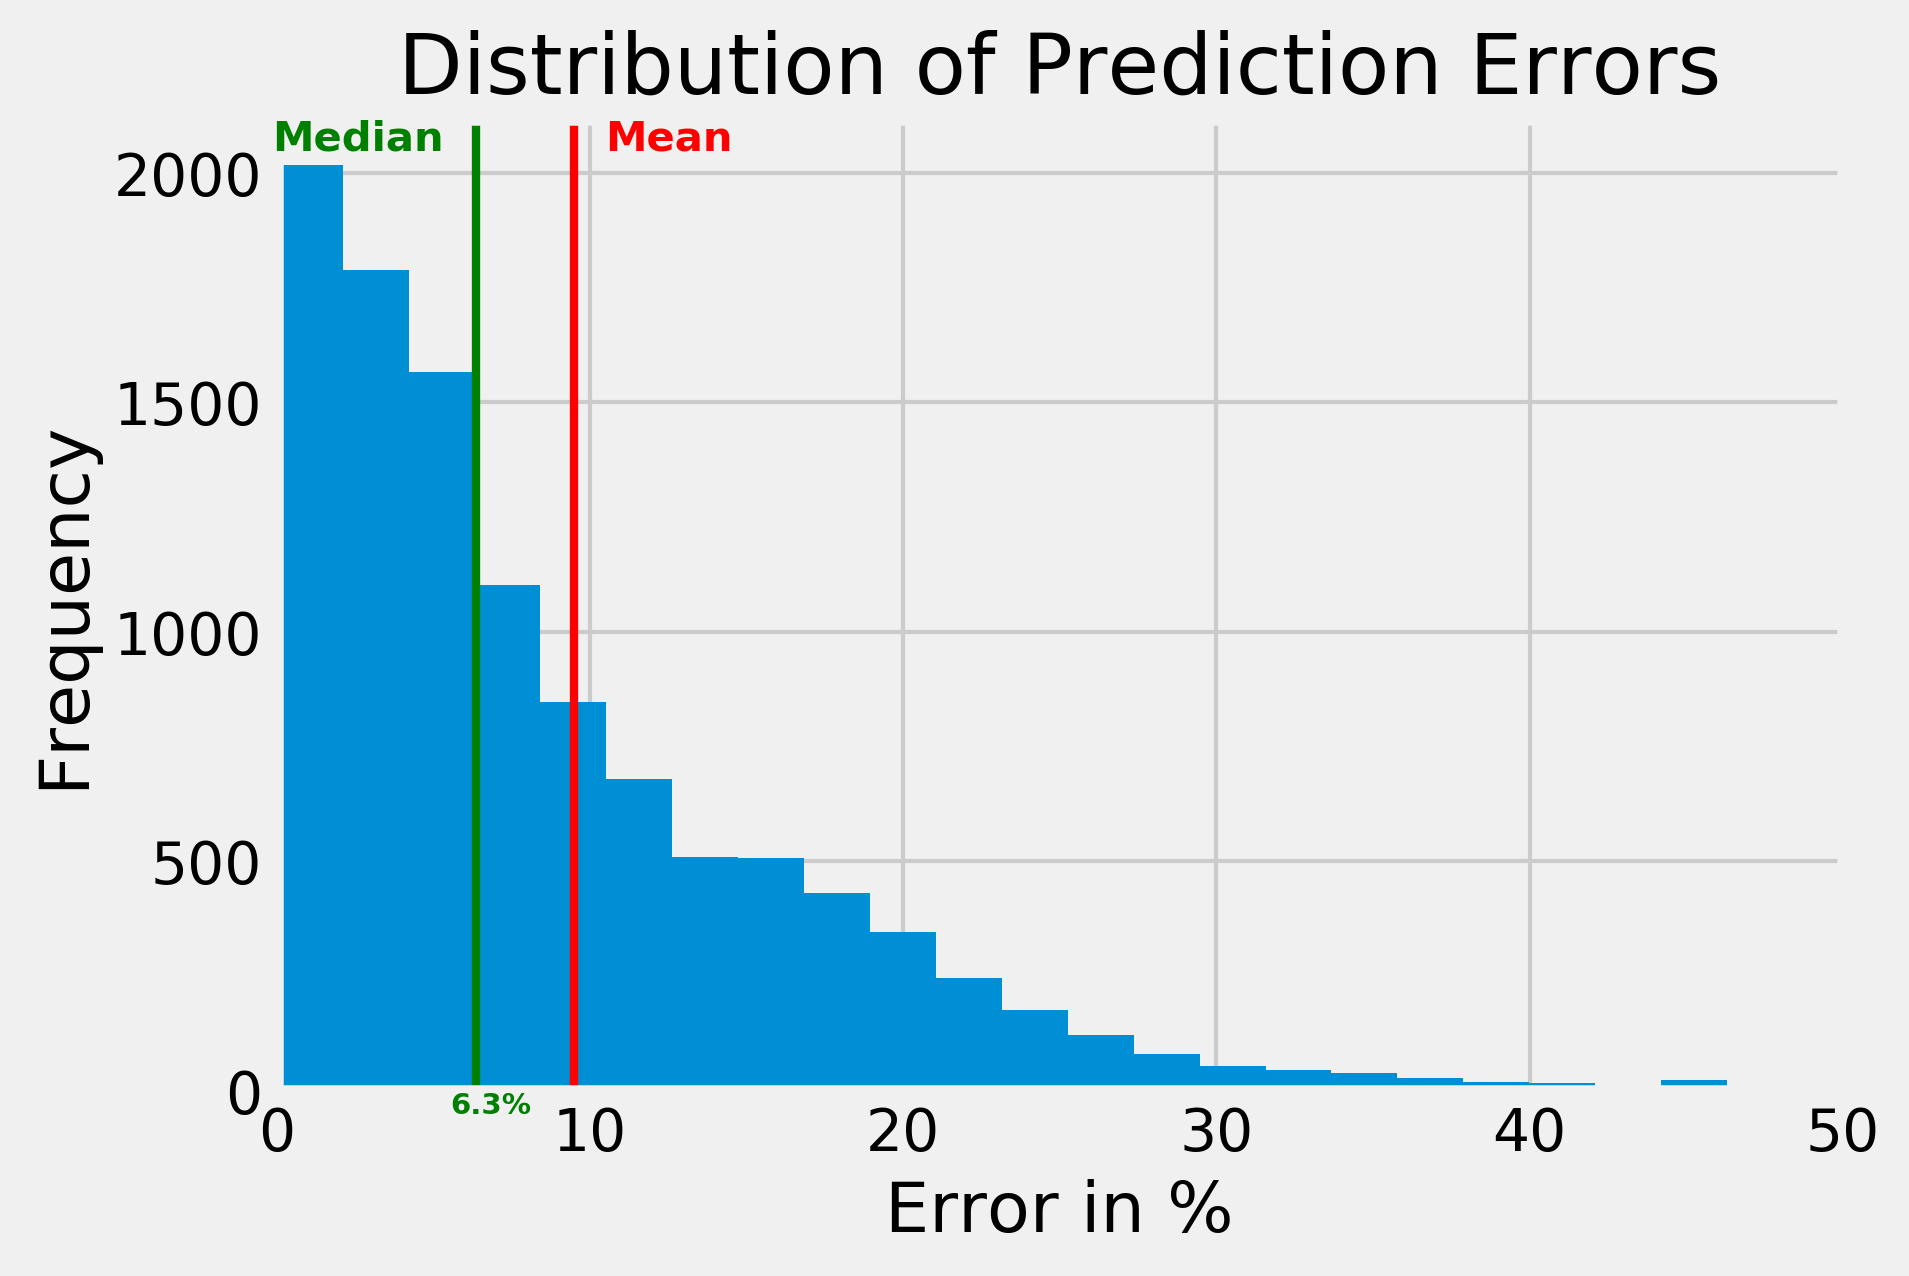

In [32]:
errors = np.abs(predictions - y_test) / y_test * 100    # List of errors as percentages

graph = errors.plot.hist(xlim=(0, 50), bins=150, title="Distribution of Prediction Errors")
plt.xlabel("Error in %")

# Mean line & label
mean = errors.mean()
plt.axvline(mean, color="red", linewidth=2)
graph.text(x=mean + 1, y=2050, s="Mean", weight='bold', color="red", fontsize=10);    # Red "Mean" line legend

# Median line & label
median = errors.median()
plt.axvline(median, color="green", linewidth=2)
graph.text(x=median - 6.5, y=2050, s="Median", weight='bold', color="green", fontsize=10);    # Green "Median" line legend
graph.text(x=median - .8, y=-50, s=str(round(median, 1)) + "%", weight='bold', color="green", fontsize=7);    # Median value text

# plt.savefig('errors_distribution.png', bbox_inches='tight')    # Saves the graph locally

In [54]:
errors.describe()

count    10784.000000
mean         9.498694
std         11.327757
min          0.000895
25%          2.889948
50%          6.348438
75%         12.978475
max        315.686548
Name: price, dtype: float64

From the histogram and the describe() method results, we can see that:
* Most of our diamonds had their price predicted quite accurately as the distribution is very right-skewed
* The average (absolute) error is 9.5%. If we were to take a diamond randomly, we could expect to predict its price with an average error of 9.5%.
* We obtained an error of less than 2.89% for a quarter of our diamonds.
* We obtained an error of less than 6.35% for half of our diamonds.
* We obtained an error of less than 13% for two-thirds of our diamonds.
* A very low number of diamonds have a very high error (up to 316%!). Some are not represented on the histogram. It is likely that these diamonds' prices do not represent their features well. They might have another unknown feature that changed their price dramatically.

Overall, our model is reliable, except for a few outliers.

## A quick look at our outliers
We know that our model got a particular high error on a few diamonds. But how many of them are there?

In [51]:
errors_gt_50 = (errors > 50).sum()
error_gt_50_proportion = errors_gt_50 / len(errors)

errors_gt_100 = (errors > 100).sum()
error_gt_100_proportion = errors_gt_100 / len(errors)

print("{} diamonds ({}%) had their price predicted with an error of at least 50%".format(errors_gt_50, round(error_gt_50_proportion, 4)))
print("{}  diamonds ({}%) had their price predicted with an error of at least 100%".format(errors_gt_100, round(error_gt_100_proportion, 4)))

117 diamonds (0.0108%) had their price predicted with an error of at least 50%
13  diamonds (0.0012%) had their price predicted with an error of at least 100%


Our outliers are very rare.
We obtained prices that are 50% off reality for 1 in a thousand diamonds, and prices off by 100% (double the price as we can't have a price of 0) for about 1 in ten thousand diamonds.

## Another visualization of our prediction errors
We can also visual our residuals (errors without applying the absolute function) in a scatter plot.

In this scatter plot we will visualize the standardized errors (mean of 0 & standard deviation of 1) on y with the prices on x.

In [33]:
residuals = predictions - y_test
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

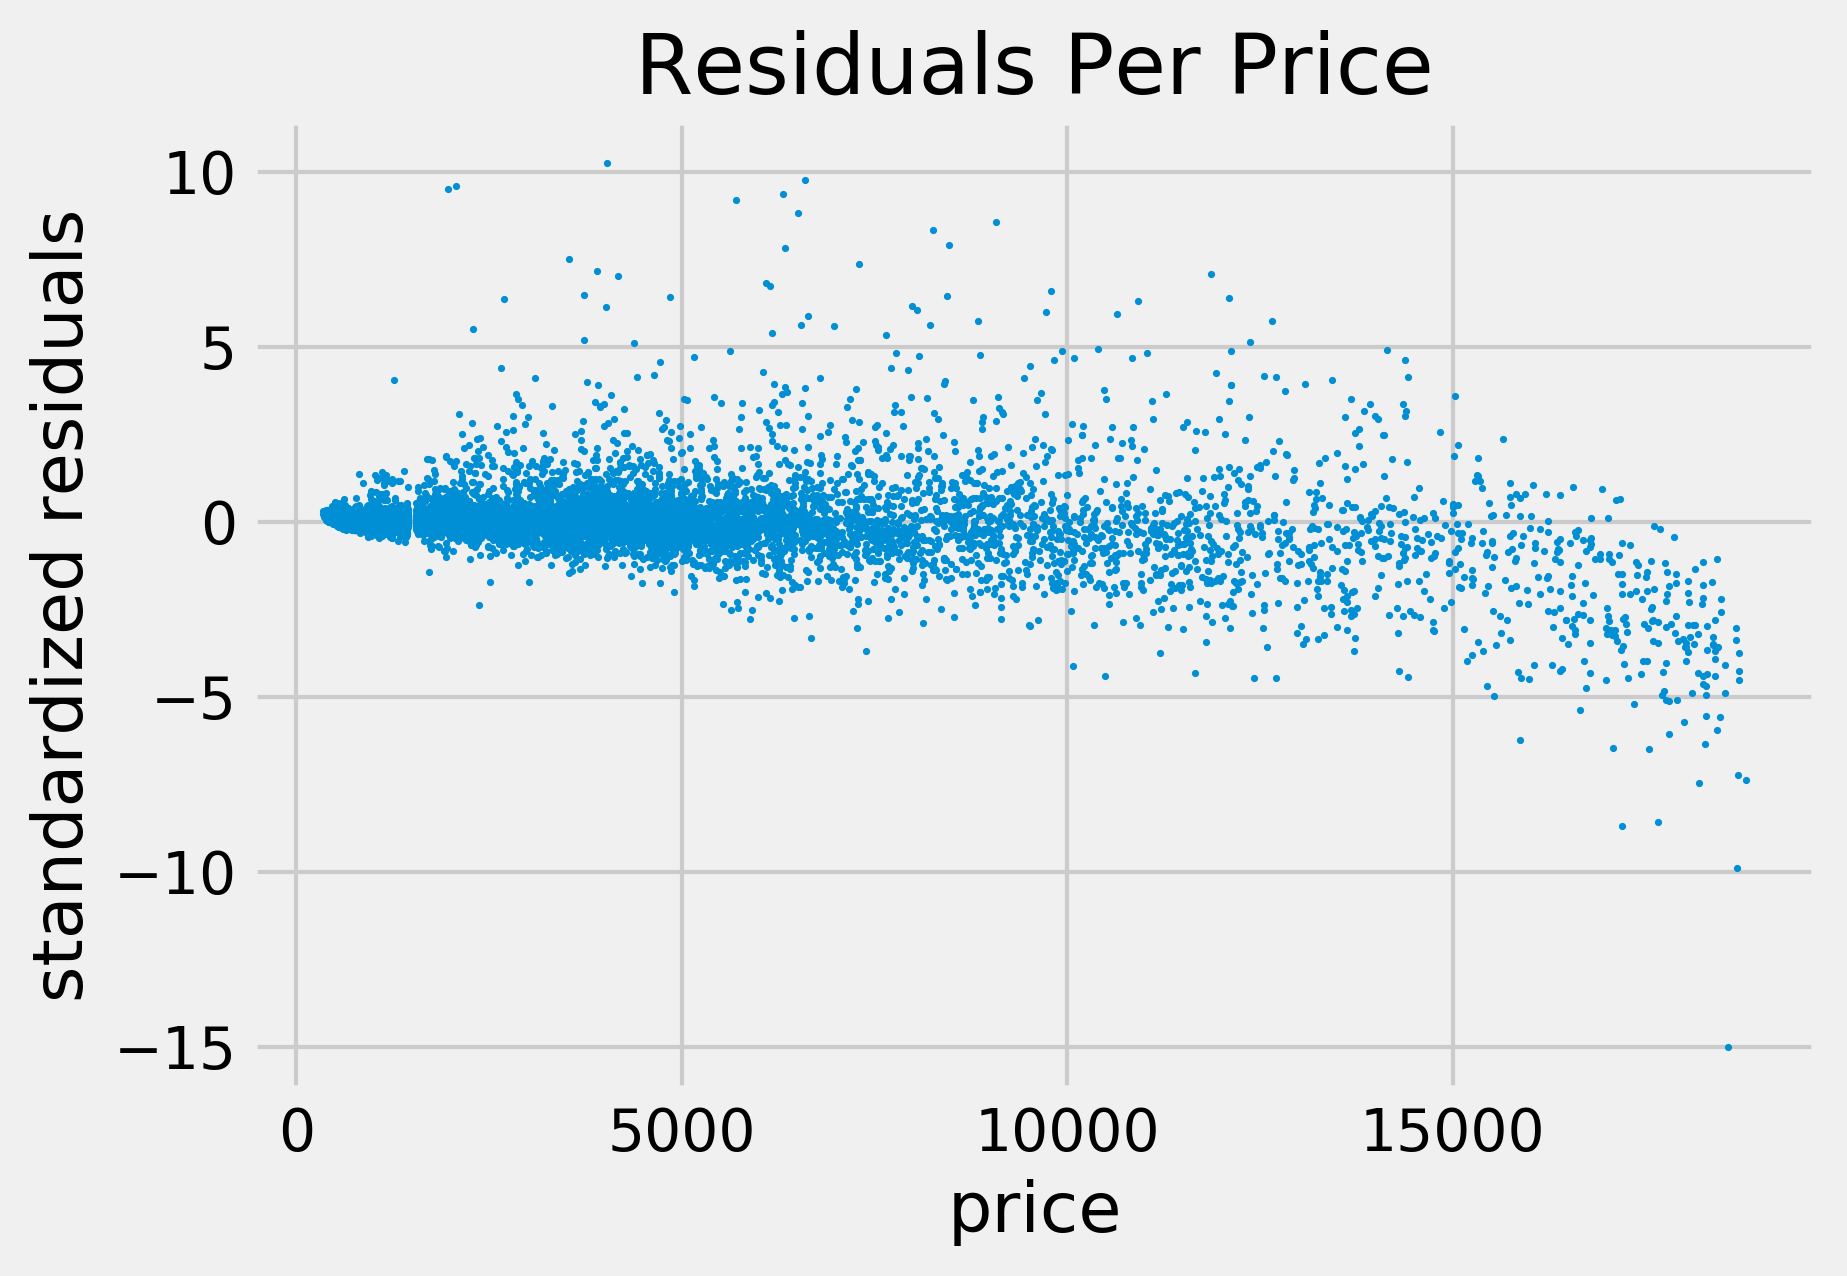

In [34]:
plt.scatter(y_test, standardized_residuals, s=1.5)
plt.title("Residuals Per Price")
plt.xlabel("price")
plt.ylabel("standardized residuals")

# plt.savefig('residuals.png', bbox_inches='tight')    # Saves the graph locally

We notice that:
* There is cluster of points that have a low price and a low absolute residual: our model is good at predicting the price of diamonds having a relatively low cost
* As the price increases, the number of points being far from a residual of 0 slowly increases: our model slowly gets worse as we increase the price of our diamonds. 
* We can see our rare extreme outliers
* The diamond prices our model overestimates are mostly for diamonds of medium price or lower, while the diamond prices our model underestimates are mostly for diamonds of high price

## Conclusion
We managed to train a model that is capable of reliably predicting the price of a diamond using its features. Our best model is a Random Forest Regressor with a coefficient of determination R² of 97%.

Our model tends to be better at predicting prices of relatively low-cost diamonds than expensive ones, and failed for less than 1 in a 1000 diamonds.

## Next Steps
We could add to our project by:
* Looking into our residual outliers more closely: do they have something in common that would indicate a flaw in our model?
* Finding diamond data that is not already present in the data used in this project to predict their prices and see if our model generalizes well.
* Trying more models. I tried the ones I learned about, but there are many more.